# Submission by Satya Prakash
Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
import pathlib
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import experimental
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D

In [2]:
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('/content/drive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment_images/Train')
data_dir_test = pathlib.Path('/content/drive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment_images/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2249
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180
num_classes = 9

Use 80% of the images for training, and 20% for validation.

In [7]:
## Create train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  labels = "inferred",
  label_mode = "categorical",
  color_mode = "rgb",
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2249 files belonging to 9 classes.
Using 1800 files for training.


In [8]:
## Create validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  labels = "inferred",
  label_mode = "categorical",
  color_mode = "rgb",
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2249 files belonging to 9 classes.
Using 449 files for validation.


In [9]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_ds).numpy())
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds).numpy())

Number of training batches: 57
Number of validation batches: 15


In [10]:
# List out all the classes of skin cancer and store them in a list.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [11]:
train_ds.class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

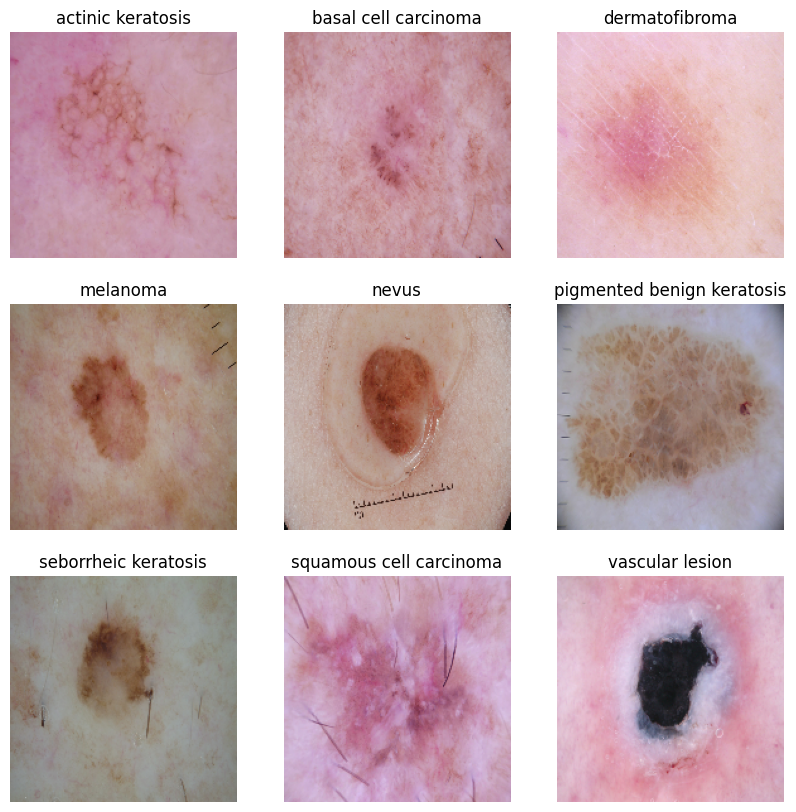

In [12]:
plt.figure(figsize=(10, 10))

# Loop through each class
for i, class_name in enumerate(class_names):
    image_found = False
    # Iterate through batches until an image of the class is found
    for images, labels in train_ds:
        # Find indices of images belonging to the current class
        indices = tf.where(tf.argmax(labels, axis=1) == i)
        if indices.shape[0] > 0:  # Check if any images were found
            # Extract the numerical index from the tensor
            index = indices[0].numpy()[0]
            # Select the image using the numerical index
            image = images[index]
            image_found = True
            break  # Exit the loop if an image is found

    if image_found:
        # Create subplot and display image
        plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(class_name)
        plt.axis("off")
    else:
        print(f"No image found for class: {class_name}")

plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
model = Sequential()

# Input normalization layer
model.add(experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

# First convolutional block
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# Second convolutional block
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# Classification block
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [15]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# Build the model
model.build(input_shape=(img_height, img_width, 3))

# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 32)        9248      
                                                        

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 622s 3s/step - loss: 2.4629 - accuracy: 0.2133 - val_loss: 1.9455 - val_accuracy: 0.2539
Epoch 2/20
57/57 [==============================] - 4s 65ms/step - loss: 1.8171 - accuracy: 0.3306 - val_loss: 1.5625 - val_accuracy: 0.4811
Epoch 3/20
57/57 [==============================] - 4s 68ms/step - loss: 1.5806 - accuracy: 0.4533 - val_loss: 1.5640 - val_accuracy: 0.4543
Epoch 4/20
57/57 [==============================] - 4s 66ms/step - loss: 1.4454 - accuracy: 0.5100 - val_loss: 1.5651 - val_accuracy: 0.4120
Epoch 5/20
57/57 [==============================] - 4s 67ms/step - loss: 1.4056 - accuracy: 0.4994 - val_loss: 1.5119 - val_accuracy: 0.4566
Epoch 6/20
57/57 [==============================] - 4s 68ms/step - loss: 1.3219 - accuracy: 0.5472 - val_loss: 1.4451 - val_accuracy: 0.4922
Epoch 7/20
57/57 [==============================] - 4s 70ms/step - loss: 1.1877 - accuracy: 0.5883 - val_loss: 1.4155 - val_accuracy: 0.5323
Epoch 8/20
57

### Visualizing training results

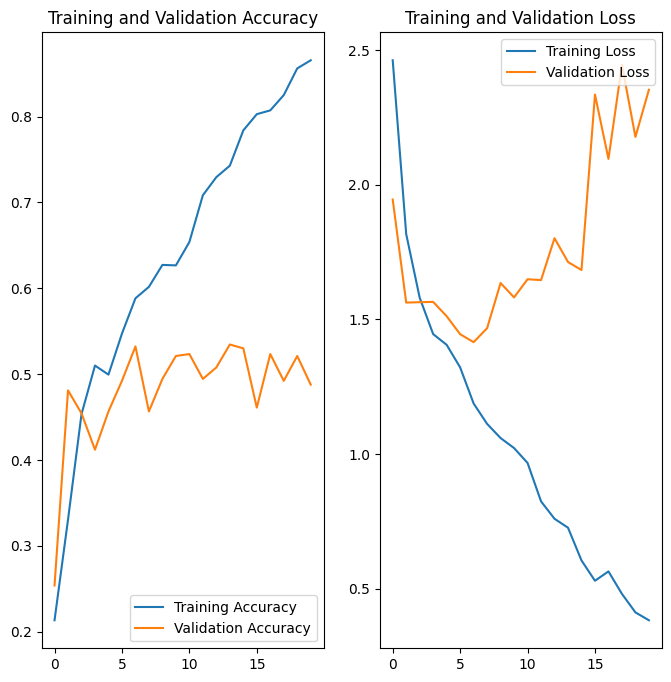

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The model is clearly overfitting with high training accuracy and low validation accuracy.

### Create new model to fix overfitting, compile and train the model


In [19]:
model = Sequential()

# Input normalization layer
model.add(experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

# First convolutional block
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.3))

# Second convolutional block
model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.3))

# Classification block
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


### Compiling the model

In [20]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Build the model
model.build(input_shape=(img_height, img_width, 3))

# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 90, 90, 16)        4624      
                                                      

### Training the model

In [21]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 9s 92ms/step - loss: 2.0916 - accuracy: 0.1906 - val_loss: 2.1275 - val_accuracy: 0.2049
Epoch 2/20
57/57 [==============================] - 5s 82ms/step - loss: 2.0346 - accuracy: 0.2078 - val_loss: 2.1091 - val_accuracy: 0.2094
Epoch 3/20
57/57 [==============================] - 5s 82ms/step - loss: 2.0211 - accuracy: 0.2250 - val_loss: 2.0053 - val_accuracy: 0.2494
Epoch 4/20
57/57 [==============================] - 5s 84ms/step - loss: 1.8818 - accuracy: 0.2939 - val_loss: 1.8189 - val_accuracy: 0.3452
Epoch 5/20
57/57 [==============================] - 5s 82ms/step - loss: 1.8418 - accuracy: 0.3194 - val_loss: 1.8993 - val_accuracy: 0.3051
Epoch 6/20
57/57 [==============================] - 5s 81ms/step - loss: 1.7061 - accuracy: 0.3950 - val_loss: 1.7003 - val_accuracy: 0.4343
Epoch 7/20
57/57 [==============================] - 5s 82ms/step - loss: 1.6277 - accuracy: 0.4272 - val_loss: 1.6576 - val_accuracy: 0.4365
Epoch 8/20
57

### Visualizing the results

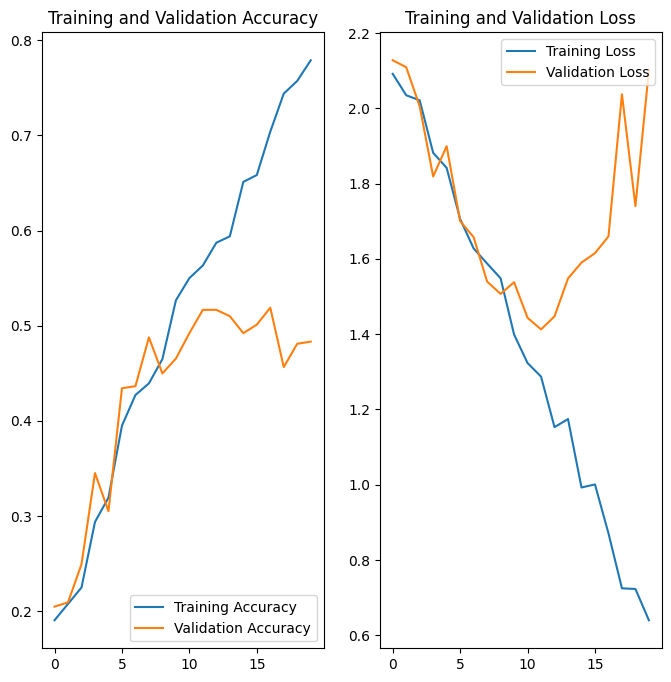

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<B>We can see that after adding dropouts in the layer, now the problem of overfitting is somewhat solved. However the overall accuracy is not that high. Lets look at what can be done more to improve the accuracy score.</B>

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
# Initialize counts
total_images = 0
category_counts = {}

# Iterate and count total number of images fot each category in training dataset
for images, labels in train_ds:
    batch_size = images.shape[0]
    total_images += batch_size

    for label in tf.argmax(labels, axis=1):
        category_index = label.numpy()
        category_name = class_names[category_index]  # Get category name
        category_counts[category_name] = category_counts.get(category_name, 0) + 1

# Print distribution
print("Total images:", total_images)
for category_name, count in category_counts.items():
    percentage = (count / total_images) * 100
    print(f"Category {category_name}: {count} images ({percentage:.2f}%)")

Total images: 1800
Category squamous cell carcinoma: 137 images (7.61%)
Category nevus: 276 images (15.33%)
Category dermatofibroma: 77 images (4.28%)
Category basal cell carcinoma: 309 images (17.17%)
Category pigmented benign keratosis: 380 images (21.11%)
Category melanoma: 354 images (19.67%)
Category actinic keratosis: 88 images (4.89%)
Category vascular lesion: 117 images (6.50%)
Category seborrheic keratosis: 62 images (3.44%)


#### Write your findings here:
#### - Which class has the least number of samples?
We can see that seborrheic keratosis has only 62 images in the training dataset which is little more than 3%.
#### - Which classes dominate the data in terms proportionate number of samples?
We can see that pigmented benign keratosis has highest number of samples with 380 images in the training dataset which is almost 21%.

<B> So we can easily conclude that the dataset is imbalanced </B>


#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [24]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [25]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [26]:
path_to_training_dataset='/content/drive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment_images/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.


Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment_images/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E1F041E40A0>: 100%|██████████| 500/500 [00:20<00:00, 23.95 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment_images/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E1F92D135B0>: 100%|██████████| 500/500 [00:22<00:00, 22.41 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment_images/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E1E9045E620>: 100%|██████████| 500/500 [00:23<00:00, 21.66 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment_images/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E1F040A49A0>: 100%|██████████| 500/500 [01:25<00:00,  5.87 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment_images/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=962x676 at 0x7E1F04199F60>: 100%|██████████| 500/500 [01:21<00:00,  6.12 Samples/s]


Initialised with 472 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment_images/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E1E907AC220>: 100%|██████████| 500/500 [00:18<00:00, 27.70 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment_images/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E1F04431000>: 100%|██████████| 500/500 [00:42<00:00, 11.79 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment_images/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E1F041C2380>: 100%|██████████| 500/500 [00:19<00:00, 25.54 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment_images/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E1F07A1E470>: 100%|██████████| 500/500 [00:17<00:00, 27.97 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [28]:
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/drive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment_images/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030408.jpg_eed0e418-76dc-4ad5-a3ff-69d3e0babbd9.jpg',
 '/content/drive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment_images/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031922.jpg_66a8407e-9a2b-4d77-a772-c7d632874342.jpg',
 '/content/drive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment_images/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029915.jpg_8458bd61-26d5-4e91-8231-8c8c14f10e49.jpg',
 '/content/drive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment_images/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027452.jpg_dc36532f-57df-4fd2-84e1-f7561702bbb8.jpg',
 '/content/drive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment_images/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026857.jpg_c924f9e9-da4e-4119-a203-0ca797718ed4.jpg',
 '/co

In [29]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [30]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [31]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [32]:
#new_df['Label'].value_counts()
df2['Label'].value_counts()

Label
actinic keratosis             500
basal cell carcinoma          500
nevus                         500
seborrheic keratosis          500
melanoma                      500
pigmented benign keratosis    500
vascular lesion               500
squamous cell carcinoma       500
dermatofibroma                500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

#### Create a training dataset

In [33]:
data_dir_train = pathlib.Path('/content/drive/MyDrive/Melanoma_Detection_Assignment_CNN/CNN_assignment_images/Train')
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  labels = "inferred",
  label_mode = "categorical",
  color_mode = "rgb",
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 5400 files for training.


#### Create a validation dataset

In [34]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  labels = "inferred",
  label_mode = "categorical",
  color_mode = "rgb",
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 1349 files for validation.


In [35]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_ds).numpy())
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds).numpy())

Number of training batches: 169
Number of validation batches: 43


#### Create your model (make sure to include normalization)

In [36]:
model = Sequential()

# Input normalization layer
model.add(experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

# First convolutional block
model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.45))

# Second convolutional block
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.45))

# Third convolutional block
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.45))

# Classification block
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [37]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Build the model
model.build(input_shape=(img_height, img_width, 3))

# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 180, 180, 16)      64        
 Normalization)                                                  
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 64)      9280      
                                                                 
 batch_normalization_1 (Bat  (None, 180, 180, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 90, 90, 64)       

#### **Todo:**  Train your model

In [38]:
epochs = 30

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 72s 325ms/step - loss: 2.7117 - accuracy: 0.2859 - val_loss: 8.0676 - val_accuracy: 0.1156
Epoch 2/30
169/169 [==============================] - 51s 293ms/step - loss: 1.6428 - accuracy: 0.3865 - val_loss: 11.5841 - val_accuracy: 0.1142
Epoch 3/30
169/169 [==============================] - 49s 276ms/step - loss: 1.5393 - accuracy: 0.4348 - val_loss: 3.6232 - val_accuracy: 0.2987
Epoch 4/30
169/169 [==============================] - 47s 272ms/step - loss: 1.4321 - accuracy: 0.4706 - val_loss: 2.3170 - val_accuracy: 0.4663
Epoch 5/30
169/169 [==============================] - 50s 284ms/step - loss: 1.2855 - accuracy: 0.5217 - val_loss: 8.3023 - val_accuracy: 0.1942
Epoch 6/30
169/169 [==============================] - 47s 268ms/step - loss: 1.1631 - accuracy: 0.5680 - val_loss: 3.5390 - val_accuracy: 0.3380
Epoch 7/30
169/169 [==============================] - 52s 299ms/step - loss: 1.0336 - accuracy: 0.6122 - val_loss: 1.3831 - val_a

#### **Todo:**  Visualize the model results

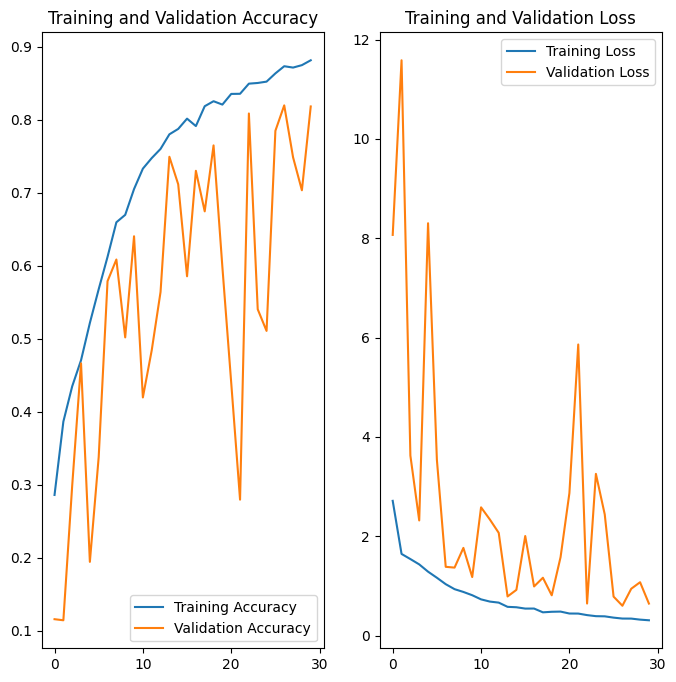

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

After balancing the dataset, the training and validation accuracy has improved significantly and there is no sign of overfitting or underfitting. The Training and validation losses has also reduced and are less than 1%.

## Conclusion
- Without the use of regularazation and dropout layer, the model tend to overfit. There is huge difference betweeh the training accuracy and validation accuracy. The validation loss is also high.
- With the inclusion of dropout layer, the problem of overfitting got somewhat solved, however the overall accuracy is not that high.
- After checking the distribution of classes in training dataset it is found that some classes have very low volume and some has very high volume.
- Augmentor was used to generate 500 images of each class so that some balance is achieved.
- After which Final model is created by doing following changes:
    - Batch normalization is added to the conv2D layers.
    - 3rd Conv2 layer block is added to capture more details
    - Dropout percentage is adjusted to counter overfitting.
- Final model gave very good accuracy and does not show any sign of overfitting or underfitting. Training and validation losses are also small.
